# Importing neccessary libs and constants

In [43]:
# base
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import emoji
import scipy

# nltk
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# tf
import tensorflow as tf
from keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
IN_PATH = 'Company Reviews'

# EDA

In [45]:
# read csv's
df_train_origin = pd.read_csv(IN_PATH + '/train.csv')
df_test_origin = pd.read_csv(IN_PATH + '/test.csv')

In [46]:
df_train_origin.describe()

,Id,Rating
count,60000.000000,60000.00000
mean,29999.500000,3.56255
std,17320.652413,1.82283
min,0.000000,1.00000
25%,14999.750000,1.00000
50%,29999.500000,5.00000
75%,44999.250000,5.00000
max,59999.000000,5.00000


In [47]:
df_train_origin.head(3)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1


In [48]:
df_train_origin.isna().sum()

Id        0
Review    0
Rating    0
dtype: int64

In [49]:
df_train_origin.Rating.unique()

array([5, 3, 1, 4, 2], dtype=int64)

In [50]:
fig = px.pie(data_frame= df_train_origin, names= df_train_origin.Rating.value_counts().index, values= df_train_origin.Rating.value_counts(), title= 'Ratings distribution diagram')
fig.show()

                 -------STOPWORDS WORDS CLOUD-------


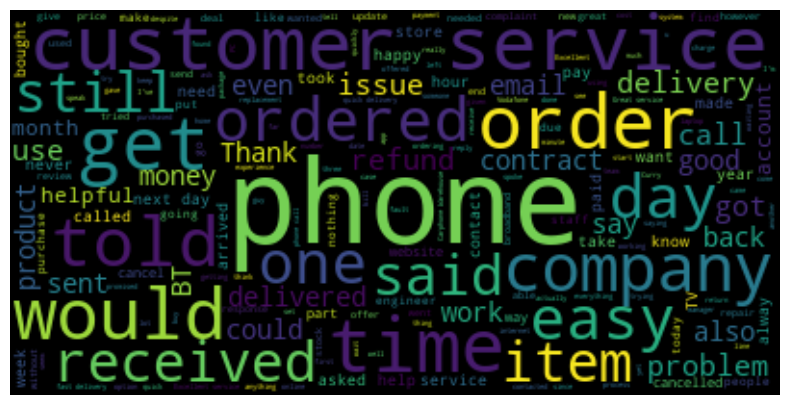

In [51]:
# Create stopword list:
stopwords = stopwords.words("english")
textt = " ".join(review for review in df_train_origin.Review)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
print('                 -------STOPWORDS WORDS CLOUD-------')
plt.rcParams['figure.figsize'] = (10,5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [52]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):    
    x = x.lower()
    x = removeHTML(x)
    x = emoji.demojize(x, delimiters=(" ", " "))
    
    # left only important words
    words = re.findall(r'\w+', x,flags = re.UNICODE) 
    important_words = filter(lambda x: x not in stopwords, words)
    x = " ".join(important_words) 
    
    x = re.sub("@\w+", '',x) # removing mentions (@)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub(r"[^\w\s]", '',x) # to remove symbols
    x = re.sub("http\w+", '',x)
    x = re.sub("\s[a-z]\s", '',x)
    x = x.strip()
    return x

df_train_origin["Review"] = df_train_origin["Review"].apply(lambda x: dataPreprocessing(x))
df_test_origin["Review"] = df_test_origin["Review"].apply(lambda x: dataPreprocessing(x))

# Feature engineering 

In [53]:
# create new features 'Postivie' - 4-5, 'Neutral' - 3, 'Negative' - 1-2
conditions = [
    (df_train_origin['Rating'] < 3),
    (df_train_origin['Rating'] >= 3 ) & (df_train_origin['Rating'] <= 4),
    (df_train_origin['Rating'] == 5)]
choices = ['Negative', 'Neutral', 'Postivie']
df_train_origin['CharRating'] = np.select(conditions, choices, default= 'Unrated')
df_train_origin.head(3)

,Id,Review,Rating,CharRating
0,0,good value great tv happy delivery next day fr...,5,Postivie
1,1,month still access account,3,Neutral
2,2,make official review product app came mum boug...,1,Negative


In [54]:
fig = px.pie(data_frame= df_train_origin.CharRating.value_counts(), values= df_train_origin.CharRating.value_counts(), names= df_train_origin.CharRating.value_counts().index, title= 'CharRatings distribution diagram')
fig.show()

In [55]:
# OHE .Rating and .CharRating
df_train_origin.Rating = pd.Categorical(df_train_origin.Rating)
ohe_columns = pd.get_dummies(df_train_origin[df_train_origin.columns[2:]])
df_modif_train = pd.concat([df_train_origin,ohe_columns], axis= 1)
df_modif_train.head(5)

,Id,Review,Rating,CharRating,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,CharRating_Negative,CharRating_Neutral,CharRating_Postivie
0,0,good value great tv happy delivery next day fr...,5,Postivie,0,0,0,0,1,0,0,1
1,1,month still access account,3,Neutral,0,0,1,0,0,0,1,0
2,2,make official review product app came mum boug...,1,Negative,1,0,0,0,0,1,0,0
3,3,fantastic extremely easy use website fantastic...,5,Postivie,0,0,0,0,1,0,0,1
4,4,far annoyed hell bt monthly pass easy abc get ...,1,Negative,1,0,0,0,0,1,0,0


In [56]:
# create len feature and explore
len_feature = []
for text in df_modif_train.Review.values:
    len_feature.append(len(text))
df_modif_train['Review_Lenght'] = len_feature

In [57]:
print(f'Lenghts less than 750 chars : {df_modif_train.Review_Lenght[df_modif_train.Review_Lenght < 750].count()/df_modif_train.shape[0] * 100}% (from all train data)')
px.box(y= df_modif_train.Review_Lenght[df_modif_train.Review_Lenght < 750],
       x= df_modif_train[df_modif_train.Review_Lenght < 750].Rating, 
       title= 'Boxplot for most reveiw lenghts by Rating', 
       color = df_modif_train[df_modif_train.Review_Lenght < 750].Rating)

Lenghts less than 750 chars : 96.46333333333334% (from all train data)


# Deep learning (Conv) model

In [58]:
# splitting train/validation/test
X_train_val_lstm, X_test_lstm, y_train_val_lstm, y_test_lstm = train_test_split(
    df_train_origin['Review'],
    df_modif_train[['Rating_1','Rating_2','Rating_3','Rating_4','Rating_5']],
    #df_train_origin['Rating'],
    test_size= 0.15, 
    random_state=133, 
    stratify=df_modif_train[['Rating_1','Rating_2','Rating_3','Rating_4','Rating_5']])
    #stratify=df_train_origin['Rating'])

In [59]:
# get validation set
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm  = train_test_split(
    X_train_val_lstm, 
    y_train_val_lstm, 
    test_size= 0.1, 
    random_state=133,
    stratify= y_train_val_lstm)

In [60]:
# tokenize the reviews
vocabulary_size = 750

# create the tokenizer that comes with Keras.
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train_val_lstm)

In [61]:
X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_val_seq = tokenizer.texts_to_sequences(X_val_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

In [62]:
MAX_LEN= 700
X_train_seq_padded = pad_sequences(X_train_seq, maxlen= MAX_LEN)
X_val_seq_padded  = pad_sequences(X_val_seq, maxlen= MAX_LEN)
X_test_seq_padded  = pad_sequences(X_test_seq, maxlen= MAX_LEN)

In [63]:
from sklearn.utils import class_weight
sklearn_weights = class_weight.compute_class_weight('balanced', classes= np.unique(df_train_origin['Rating']), y= df_train_origin['Rating'])
sklearn_weights = dict(enumerate(sklearn_weights))

#sklearn_weights = {0: 1, 1: 25, 2: 30, 3: 50, 4: 5}
sklearn_weights[0] = 1.2
#sklearn_weights[3] = 3.8
sklearn_weights[4] = 1.2
sklearn_weights

{0: 1.2,
 1: 7.366482504604051,
 2: 7.14711137581894,
 3: 3.582089552238806,
 4: 1.2}

In [76]:
model = Sequential()
model.add(layers.Embedding(vocabulary_size, 32, input_length=MAX_LEN))
model.add(layers.Conv1D(filters= 64, activation='relu', kernel_size=3, input_shape= (1,1,MAX_LEN)))
model.add(layers.MaxPooling1D())
model.add(layers.Dropout(0.5))
#model.add(layers.Bidirectional(layers.LSTM(128,dropout=0.5)))
model.add(layers.Flatten())
model.add(layers.Dense(120,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(60,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(5,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', 'mae'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 700, 32)           24000     
                                                                 
 conv1d_3 (Conv1D)           (None, 698, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 349, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 349, 64)           0         
                                                                 
 flatten_3 (Flatten)         (None, 22336)             0         
                                                                 
 dense_9 (Dense)             (None, 120)               2680440   
                                                      

In [77]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.15,
    verbose=1)

In [78]:
model.fit(X_train_seq_padded, 
           y_train_lstm, 
           epochs=20,
           validation_data=(X_val_seq_padded, y_val_lstm), 
           verbose=1, 
           callbacks= [early_stopping_callback, reduce_lr_callback],
           class_weight= sklearn_weights)

Epoch 1/20
1435/1435 [==============================] - 49s 33ms/step - loss: 0.5727 - accuracy: 0.7969 - mae: 0.1662 - val_loss: 0.2212 - val_accuracy: 0.7925 - val_mae: 0.1499 - lr: 0.0010
Epoch 2/20
1435/1435 [==============================] - 64s 44ms/step - loss: 0.5013 - accuracy: 0.8142 - mae: 0.1367 - val_loss: 0.1977 - val_accuracy: 0.8253 - val_mae: 0.1338 - lr: 0.0010
Epoch 3/20
1435/1435 [==============================] - 65s 45ms/step - loss: 0.4795 - accuracy: 0.8191 - mae: 0.1292 - val_loss: 0.1860 - val_accuracy: 0.8392 - val_mae: 0.1255 - lr: 0.0010
Epoch 4/20
1435/1435 [==============================] - 49s 34ms/step - loss: 0.4645 - accuracy: 0.8192 - mae: 0.1248 - val_loss: 0.1776 - val_accuracy: 0.8382 - val_mae: 0.1139 - lr: 0.0010
Epoch 5/20
1435/1435 [==============================] - 61s 43ms/step - loss: 0.4502 - accuracy: 0.8188 - mae: 0.1203 - val_loss: 0.1977 - val_accuracy: 0.8073 - val_mae: 0.1325 - lr: 0.0010
Epoch 6/20
1435/1435 [=======================

In [80]:
model.evaluate(X_test_seq_padded,y_test_lstm)

282/282 [==============================] - 1s 5ms/step - loss: 0.1729 - accuracy: 0.8413 - mae: 0.1132


[0.17290908098220825, 0.8413333296775818, 0.11323521286249161]

282/282 [==============================] - 1s 5ms/step


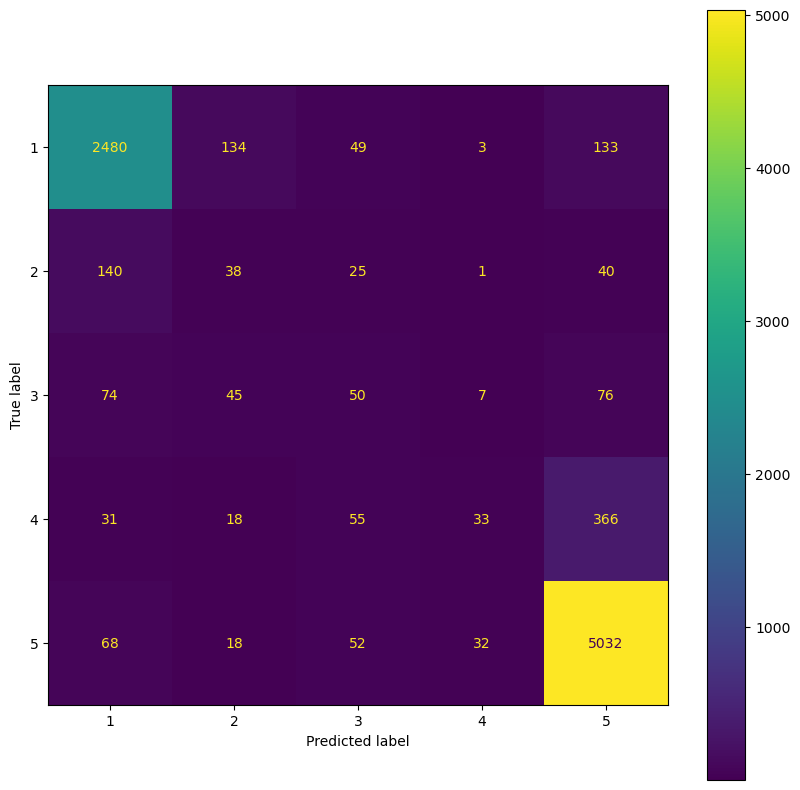

In [68]:
plt.rcParams['figure.figsize'] = (10,10)
ConfusionMatrixDisplay.from_predictions(np.argmax(np.array(y_test_lstm), axis=1) +1, np.argmax(model2.predict(X_test_seq_padded),axis=1) + 1)

In [69]:
model.predict(X_test_seq_padded)

282/282 [==============================] - 2s 5ms/step


array([[9.77164447e-01, 7.95072317e-03, 4.73054184e-04, 3.06855608e-03,
        1.22575574e-02],
       [8.10259394e-03, 1.86244852e-03, 6.51397463e-03, 1.53022498e-01,
        7.84040332e-01],
       [9.95956242e-01, 3.95075837e-03, 3.13294076e-05, 1.10630375e-04,
        1.73870430e-04],
       ...,
       [1.39736637e-01, 2.81470269e-01, 3.76785249e-01, 1.68844000e-01,
        1.55719966e-01],
       [9.96750057e-01, 3.34747275e-03, 1.76768808e-05, 8.69291471e-05,
        1.13110596e-04],
       [7.24001527e-01, 2.13902295e-01, 1.48712695e-02, 2.92272866e-03,
        1.91608525e-03]], dtype=float32)

In [70]:
model.save('model.h5')

In [71]:
# make predictions
t1 = tokenizer.texts_to_sequences(df_test_origin['Review'])
X_test_tokenized = pad_sequences(t1, maxlen= MAX_LEN)
#X_test_tokenized = pad_sequences(tokenizer.texts_to_sequences(df_test_origin['Review']))
lstm_preds = model.predict(X_test_tokenized)

1250/1250 [==============================] - 6s 5ms/step


In [72]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]


final_results = [] 
for preds in lstm_preds:
    if len(find_indices(preds, lambda e: e > 0.5)) == 0:
        if len(find_indices(preds, lambda e: (e < 0.5 and e >= 0.3))) != 0:
            pred_pair = find_indices(preds, lambda e: (e < 0.5 and e >= 0.3))
            result = (pred_pair[0] + pred_pair[-1])/2 + 1
            final_results.append(result)
        else:
            final_results.append(np.argmax(preds) +1)
            continue
    else:
        final_results.append(np.argmax(preds) +1)
        continue
        
len(final_results), lstm_preds.shape

(40000, (40000, 5))

In [73]:
submsn = pd.DataFrame()
submsn['Id'] = df_test_origin['Id']

# rating values fill
submsn['Rating'] = np.argmax(lstm_preds, axis= 1) +1
#submsn['Rating'] = final_results
submsn.to_csv('lstm_submit.csv', index= False)
